In [1]:
import pandas as pd
import geopandas as gpd
import shapely

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def load_shape(x):
    try:
        return shapely.wkt.loads(x)
    except:
        return shapely.geometry.shape(json.loads(x))

def load_geos(df: pd.DataFrame) -> gpd.GeoDataFrame:
    gdf = gpd.GeoDataFrame(df[(~pd.isna(df.geometry))])
    gdf['geometry'] = [load_shape(x) for x in tqdm(gdf['geometry'], total=len(gdf))]    
    gdf = gdf.set_geometry('geometry')
    gdf.set_crs(crs="EPSG:4326", inplace=True)
    return gdf

def add_borough(s_segments: pd.DataFrame) -> pd.DataFrame:
    print('adding borough')
    zips_x_borough = pd.read_csv('data/nyc_borough_by_zip.csv')
    zips_x_borough.drop_duplicates(inplace=True)
    s_segments['ZIP'] = s_segments['L_ZIP'].combine_first(s_segments['R_ZIP'])
    correct_zip = s_segments[(pd.isna(s_segments['ZIP'])) & (s_segments['ST_NAME'] != 'CONNECTOR')]\
        .to_crs(crs="3857").sjoin_nearest(s_segments[(~pd.isna(s_segments['ZIP'])) & (s_segments['ST_NAME'] != 'CONNECTOR')]\
            .to_crs(crs="3857"))[['ZIP_right', 'PHYSICALID_left']].drop_duplicates(subset='PHYSICALID_left')

    print(len(s_segments))
    ret_df = s_segments.merge(correct_zip, how='left', left_index=True, right_index=True)
    ret_df['ZIP'] = ret_df['ZIP'].combine_first(ret_df['ZIP_right'])
    ret_df.dropna(subset='ZIP', inplace=True)
    ret_df['ZIP'] = ret_df['ZIP'].astype(int)
    ret_df = ret_df.merge(zips_x_borough, how='inner', left_on='ZIP', right_on='zip_code')
    print(len(ret_df))
    return ret_df

def load_streets(with_borough=False):
    streets = gpd.read_file('data/Centerline_20240520')
    streets.to_crs(crs="EPSG:4326", inplace=True)
    # remove irreveleant street segments
    streets = streets[~((streets['ST_LABEL'].isin(['ALLEY', 'DRIVEWAY', 'CONNECTOR', 'UNNAMED ST', 'WHITESTONE EXPRESSWAY NB EN', 'THROGS NECK EXPRESSWAY SB ET', 'United Nations Avenue N', 'United Nations Avenue S'])) |
                        (streets['ST_LABEL'].str.contains('FERRY RTE')) |
                        (streets['ST_LABEL'].str.contains('FERRY MAINTENANCE')) |
                        (streets['ST_LABEL'].str.contains('FERRY ROUTE')) |
                        (streets['ST_LABEL'].str.contains('BIKE PTH')) |
                        (streets['ST_LABEL'].str.contains('BIKE PATH')) |
                        (streets['ST_LABEL'].str.contains('BIKE CONN')) |
                        (streets['ST_LABEL'].str.contains('TUNL')) |
                        (streets['ST_LABEL'].str.contains(' STEPS')) |
                        (streets['ST_LABEL'].str.contains('BELT PARKWAY')) |
                        (streets['ST_LABEL'].str.contains('HUTCHINSON RIVER')) |
                        (streets['ST_LABEL'].str.contains('HUTCHINSON RVR')) |
                        (streets['ST_LABEL'].str.contains('DRIVEWY')) |
                        (streets['ST_LABEL'].str.contains('PEDESTIRAN')) | 
                        (streets['ST_LABEL'].str.contains('PORT RICHMOND WATER PLANT')) |
                        #(streets['ST_LABEL'].str.contains('HWY')) |
                        #(streets['ST_LABEL'].str.contains('EXPY')) |
                        (streets['ST_LABEL'].str.contains(' ET ')) | # exit abbreviation
                        (streets['ST_LABEL'].str.contains(' EN ')) | # entrance abbreviation
                        (streets['ST_LABEL'].str.contains('NB EN')) |
                        (streets['ST_LABEL'].str.contains('SB EN')) |
                        (streets['ST_LABEL'].str.contains('NB ET')) |
                        (streets['ST_LABEL'].str.contains('SB ET')) |
                        (streets['ST_LABEL'].str.contains('PARK EN')) |
                        (streets['ST_LABEL'].str.contains('PARK ET')) |
                        (streets['ST_LABEL'].str.contains('EXIT')) |
                        (streets['ST_LABEL'].str.contains('RAMP')) |
                        (streets['ST_LABEL'].str.contains('ENTRANCE')) |
                        (streets['ST_LABEL'].str.contains('DVWY')) |
                        (streets['ST_LABEL'].str.contains('BQE')) |
                        (streets['ST_LABEL'].str.contains('BROOKLYN QUEENS EXPY')) |
                        (streets['ST_LABEL'].str.contains('PARK TRAIL')) |
                        (streets['ST_LABEL'].str.contains(' BRG')) |
                        (streets['ST_LABEL'].str.contains(' BRIDGE')) |
                        (streets['ST_LABEL'].str.contains('TRL')) |
                        (streets['ST_LABEL'].str.contains('PED PTH')) |
                        (streets['ST_LABEL'].str.contains('PED PATH')) |
                        (streets['ST_LABEL'].str.contains('PARK PTH')) |
                        (streets['ST_LABEL'].str.contains('BIKE AND PED PTH')) |
                        (streets['ST_LABEL'].str.contains('PARK PATH')) |
                        (streets['ST_LABEL'].str.contains('ACCESS RD')) |
                        (streets['ST_LABEL'].str.contains('ACCESS ROAD')) |
                        (streets['ST_LABEL'].str.contains(' CONNECTOR')) |
                        (streets['ST_LABEL'].str.contains('CORRECTIONAL')) |
                        (streets['ST_LABEL'].str.contains('OVERPASS')) |
                        (streets['ST_LABEL'].str.contains('UNDERPASS')) |
                        (streets['ST_LABEL'].str.contains(' OPAS')) |
                        (streets['ST_LABEL'].str.contains('PARKWAY')) |
                        (streets['ST_LABEL'].str.contains('PWKY')) |
                        (streets['ST_LABEL'].str.contains('WWTP')) |
                        (streets['ST_LABEL'].str.contains('FOOTBRIDGE')) |
                        (streets['ST_LABEL'].str.contains('TURNAROUND')) |
                        (streets['ST_LABEL'].str.contains(' PED ')) |
                        (streets['ST_LABEL'].str.contains('PEDESTRIAN'))
                        )]
    streets.loc[(streets['ST_LABEL'] == 'PARK AVE VIADUCT') | (streets['ST_LABEL'] == 'PARK AVE S'), 'ST_LABEL'] = 'PARK AVE'
    streets.loc[(streets['ST_LABEL'].isin(['WASHINGTON SQ E', 'WASHINGTON SQ W', 'WASHINGTON SQ N', 'WASHINGTON SQ S'])), 'ST_LABEL'] = 'WASHINGTON SQ'
    streets.loc[(streets['ST_LABEL'].isin(['STADIUM PL N', 'STADIUM PL S'])), 'ST_LABEL'] = 'STADIUM PL'
    streets.loc[(streets['ST_LABEL'].isin(['AVE OF THE STATES N', 'AVE OF THE STATES S'])), 'ST_LABEL'] = 'AVE OF THE STATES'
    streets.loc[(streets['ST_LABEL'] == 'PORT AUTHORITY BUS TERMINAL EN'), 'ST_LABEL'] = 'PORT AUTHORITY BUS TERMINAL ENTRANCE'
    streets.loc[(streets['ST_LABEL'] == 'E MOUNT EDEN AVENUE'), 'ST_LABEL'] = 'EAST MOUNT EDEN AVENUE'
    if with_borough:
        return add_borough(streets)
    else:
        return streets

In [3]:
display_streets = load_geos(pd.read_csv('data/display_streets.csv'))
display_streets.head()

  0%|          | 0/9581 [00:00<?, ?it/s]

ST_LABEL    borough                                        segment_ids  \
0       1 AVE      Bronx  {64576, 187004, 64569, 64571, 64572, 64573, 64...   
1       1 AVE   Brooklyn  {36755, 36756, 36757, 36758, 36759, 36760, 367...   
2       1 AVE  Manhattan  {2571, 2572, 2574, 2577, 2580, 2581, 2582, 258...   
3       1 AVE     Staten   {104392, 104393, 104394, 104395, 104397, 170255}   
4  1 AVE LOOP  Manhattan   {103776, 103777, 103778, 192793, 103774, 103775}   

                                            geometry    display_label  
0  LINESTRING (-73.80725 40.82236, -73.80699 40.8...       1st Avenue  
1  MULTILINESTRING ((-74.0127 40.65659, -74.01327...       1st Avenue  
2  MULTILINESTRING ((-73.98864 40.72293, -73.9885...       1st Avenue  
3  MULTILINESTRING ((-74.15257 40.59797, -74.1511...       1st Avenue  
4  LINESTRING (-73.9815 40.73262, -73.98143 40.73...  1st Avenue Loop

In [4]:
intersections = pd.read_csv('data/street_intersections.csv')
intersections.columns = ['intersection_id', 'street1_name', 'street1_borough', 'street2_name', 'street2_borough']
intersections.head()

intersection_id street1_name street1_borough    street2_name  \
0                0        1 AVE           Bronx  PENNYFIELD AVE   
1              103       12 AVE           Bronx  PENNYFIELD AVE   
2              140       13 AVE           Bronx  PENNYFIELD AVE   
3              547        3 AVE           Bronx  PENNYFIELD AVE   
4              667        5 AVE           Bronx  PENNYFIELD AVE   

  street2_borough  
0           Bronx  
1           Bronx  
2           Bronx  
3           Bronx  
4           Bronx

In [5]:
'''print(len(intersections))
intersections = display_streets.sjoin(display_streets, predicate='intersects')
intersections = intersections[['ST_LABEL_left', 'borough_left', 'ST_LABEL_right', 'borough_right']]
intersections.columns = ['street1_name', 'street1_borough', 'street2_name', 'street2_borough']
print(len(intersections))'''

"print(len(intersections))\nintersections = display_streets.sjoin(display_streets, predicate='intersects')\nintersections = intersections[['ST_LABEL_left', 'borough_left', 'ST_LABEL_right', 'borough_right']]\nintersections.columns = ['street1_name', 'street1_borough', 'street2_name', 'street2_borough']\nprint(len(intersections))"

In [6]:
def get_intersection_points(s1_name, s1_borough, s2_name, s2_borough):
    if s1_name == s2_name and s1_borough == s2_borough:
        return None
    try:
        s1 = display_streets[(display_streets['ST_LABEL'] == s1_name) & (display_streets['borough'] == s1_borough)].reset_index()['geometry'][0]
        s2 = display_streets[(display_streets['ST_LABEL'] == s2_name) & (display_streets['borough'] == s2_borough)].reset_index()['geometry'][0]
        return s1.intersection(s2)
    except:
        #no_intersect += 1
        return None
    

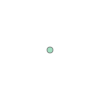

In [7]:
get_intersection_points(intersections['street1_name'][0], intersections['street1_borough'][0], intersections['street2_name'][0], intersections['street2_borough'][0])

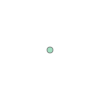

In [8]:
get_intersection_points('AVE OF THE AMERICAS', 'Manhattan', 'W 9 ST', 'Manhattan')

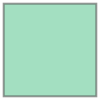

In [9]:
shapely.buffer(get_intersection_points('AVE OF THE AMERICAS', 'Manhattan', 'W 9 ST', 'Manhattan'), 10/364567.2, cap_style='square')

In [10]:
display_streets[(display_streets['ST_LABEL'] == 'CHRISTOPHER ST') & (display_streets['borough'] == 'Manhattan')].intersects(get_intersection_points('AVE OF THE AMERICAS', 'Manhattan', 'W 9 ST', 'Manhattan'))

2555    True
dtype: bool

In [11]:
street_segments = load_streets(True)[['PHYSICALID', 'ST_LABEL', 'borough', 'geometry']]
street_segments.head()

adding borough
105428
105114


PHYSICALID       ST_LABEL    borough  \
0          -1  BRUCKNER BLVD      Bronx   
1           3     BATTERY PL  Manhattan   
2           5     BATTERY PL  Manhattan   
3           6     BATTERY PL  Manhattan   
4           8     BATTERY PL  Manhattan   

                                            geometry  
0  LINESTRING (-73.90601 40.8074, -73.9057 40.807...  
1  LINESTRING (-74.01793 40.70617, -74.01787 40.7...  
2  LINESTRING (-74.01757 40.70684, -74.01712 40.7...  
3  LINESTRING (-74.01712 40.70746, -74.01663 40.7...  
4  LINESTRING (-74.01694 40.70481, -74.01705 40.7...

In [12]:
street_segments[street_segments.geometry.intersects(shapely.buffer(get_intersection_points('AVE OF THE AMERICAS', 'Manhattan', 'W 9 ST', 'Manhattan'), 10/364567.2, cap_style='square'))]

PHYSICALID             ST_LABEL    borough  \
616           804       CHRISTOPHER ST  Manhattan   
749           983  AVE OF THE AMERICAS  Manhattan   
750           984  AVE OF THE AMERICAS  Manhattan   
98526      181518               W 9 ST  Manhattan   

                                                geometry  
616    LINESTRING (-73.99919 40.73414, -73.99965 40.7...  
749    LINESTRING (-73.99956 40.73361, -73.99919 40.7...  
750    LINESTRING (-73.99919 40.73414, -73.99871 40.7...  
98526  LINESTRING (-73.99591 40.73285, -73.99833 40.7...

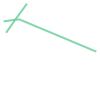

In [13]:
shapely.ops.linemerge(shapely.geometry.MultiLineString(street_segments[street_segments.geometry.intersects(shapely.buffer(get_intersection_points('AVE OF THE AMERICAS', 'Manhattan', 'W 9 ST', 'Manhattan'), 10/364567.2, cap_style='square'))]['geometry'].values))

In [14]:
intersect_geos = [get_intersection_points(a, b, c, d) for a, b, c, d in tqdm(zip(intersections['street1_name'], 
                                                                                 intersections['street1_borough'], 
                                                                                 intersections['street2_name'], 
                                                                                 intersections['street2_borough']), total=len(intersections))]

  0%|          | 0/104923 [00:00<?, ?it/s]

In [15]:
intersections['geometry'] = intersect_geos
intersections[pd.isna(intersections['geometry'])]

intersection_id           street1_name street1_borough  \
29                 7628            PYTHIAN CIR           Bronx   
149                6585          MILL RIVER RD           Bronx   
178                2571        CHANNEL VIEW RD           Bronx   
183                8444           SOUNDVIEW RD           Bronx   
184                   1                  1 AVE        Brooklyn   
...                 ...                    ...             ...   
104805             8735                SURF DR           Bronx   
104862             9054  UNIVERSITY WOODS PATH           Bronx   
104863             9055  UNIVERSITY WOODS STWY           Bronx   
104915             9754               WEST AVE           Bronx   
104916             9957                WOOD RD           Bronx   

                  street2_name street2_borough geometry  
29              PENNYFIELD AVE           Bronx     None  
149                      3 AVE           Bronx     None  
178                    MAIN ST           Bronx     None  
183                    MAIN ST           Bronx     None  
184     BUSH TERMINAL GREENWAY        Brooklyn     None  
...                        ...             ...      ...  
104805              SUNSET CIR           Bronx     None  
104862   UNIVERSITY WOODS STWY           Bronx     None  
104863   UNIVERSITY WOODS STWY           Bronx     None  
104915                WEST AVE           Bronx     None  
104916                WEST AVE           Bronx     None  

[3340 rows x 6 columns]

In [18]:
def get_intersection_geos(intersection_point: shapely.Point):
    inter_points = shapely.buffer(intersection_point, 10/364567.2, cap_style='square')
    intersect = street_segments[street_segments.geometry.intersects(inter_points)]
    new_id = '_'.join(intersect['PHYSICALID'].astype(str))
    return new_id, shapely.ops.linemerge(shapely.geometry.MultiLineString(intersect['geometry'].values))

In [19]:
intersections = intersections[(~pd.isna(intersections['geometry'])) & (intersections['street1_name'] != intersections['street2_name'])]
int_ids = []
int_geos = []
for g in tqdm(intersections['geometry'], total=len(intersections)):
    x, y = get_intersection_geos(g)
    int_ids.append(x)
    int_geos.append(y)

  0%|          | 0/91912 [00:00<?, ?it/s]

In [20]:
intersects_with_geos = {'intersection_id': int_ids, 'geometry': int_geos}
intersects_gdf = gpd.GeoDataFrame(intersects_with_geos)
intersects_gdf = intersects_gdf.set_geometry('geometry')
intersects_gdf.set_crs(crs="EPSG:4326", inplace=True)

intersection_id  \
0                             64576_93636_187004   
1                                   64661_103091   
2                            64640_103090_103091   
3                             93636_93637_100857   
4                              88464_93637_93638   
...                                          ...   
91907                        98958_144003_197276   
91908  197275_197276_197281_197284_197317_197327   
91909                          61960_61961_86078   
91910                        34966_102815_120470   
91911                       175202_175203_175204   

                                                geometry  
0      MULTILINESTRING ((-73.81251 40.82399, -73.8128...  
1      LINESTRING (-73.81114 40.8223, -73.81065 40.82...  
2      MULTILINESTRING ((-73.81201 40.82199, -73.8115...  
3      MULTILINESTRING ((-73.81232 40.8235, -73.81251...  
4      MULTILINESTRING ((-73.8123 40.82307, -73.81234...  
...                                                  ...  
91907  MULTILINESTRING ((-73.96648 40.70224, -73.9666...  
91908  MULTILINESTRING ((-73.96695 40.70261, -73.9674...  
91909  MULTILINESTRING ((-74.14447 40.62158, -74.1456...  
91910  MULTILINESTRING ((-74.11539 40.61228, -74.1169...  
91911  MULTILINESTRING ((-73.96566 40.71312, -73.9661...  

[91912 rows x 2 columns]

In [21]:
#intersects_gdf['geometry'] = intersects_gdf.normalize()
print(len(intersects_gdf))
intersects_gdf = intersects_gdf.drop_duplicates('geometry')
print(len(intersects_gdf))

91912
43298


In [22]:
streets_x_intersections = display_streets.sjoin(intersects_gdf, predicate='intersects')
streets_x_intersections.head()

ST_LABEL borough                                        segment_ids  \
0    1 AVE   Bronx  {64576, 187004, 64569, 64571, 64572, 64573, 64...   
0    1 AVE   Bronx  {64576, 187004, 64569, 64571, 64572, 64573, 64...   
0    1 AVE   Bronx  {64576, 187004, 64569, 64571, 64572, 64573, 64...   
0    1 AVE   Bronx  {64576, 187004, 64569, 64571, 64572, 64573, 64...   
0    1 AVE   Bronx  {64576, 187004, 64569, 64571, 64572, 64573, 64...   

                                            geometry display_label  \
0  LINESTRING (-73.80725 40.82236, -73.80699 40.8...    1st Avenue   
0  LINESTRING (-73.80725 40.82236, -73.80699 40.8...    1st Avenue   
0  LINESTRING (-73.80725 40.82236, -73.80699 40.8...    1st Avenue   
0  LINESTRING (-73.80725 40.82236, -73.80699 40.8...    1st Avenue   
0  LINESTRING (-73.80725 40.82236, -73.80699 40.8...    1st Avenue   

   index_right          intersection_id  
0           35  95399_95400_98888_98889  
0           33        64569_64570_95399  
0           40  64693_64694_96372_96373  
0           38  64571_64572_64694_64695  
0           45        64695_90641_90642

In [26]:
streets_x_intersections[['ST_LABEL', 'borough', 'intersection_id']].to_csv('data/streets_x_intersections.csv', index=False)
intersects_gdf.to_csv('data/intersections_geos.csv', index=False)

In [29]:
import folium
m = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles="CartoDB positron")

buildings_viz = folium.GeoJson(intersects_gdf[['geometry', 'intersection_id']].sample(10000).reset_index(), style_function=lambda x: {'opacity':0.75},
                               highlight_function=lambda x: {"color": 'red', 'opacity': 0.9}, zoom_on_click=True,
                               tooltip=folium.GeoJsonTooltip(fields=['intersection_id']))
buildings_viz.add_to(m)
m.keep_in_front(buildings_viz)
m

In [30]:
m.save('intersection_sample.html')